In [1]:
import pandas as pd
import settings as settings

import warnings
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate
import joblib as jl
import cebra.datasets
from cebra import CEBRA
import cebra.integrations.plotly
import cebra

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics

from matplotlib.collections import LineCollection
from Helpers.array_utility import list_of_list_to_1d_numpy_array

import sklearn.metrics
import numpy as np
import sys
from MARBLE import plotting, preprocessing, dynamics, net, postprocessing
import matplotlib.pyplot as plt
import torch
import MARBLE

/home/ubuntu/miniconda3/envs/MARBLE/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Define decoding function with kNN decoder. For a simple demo, we will use the fixed number of neighbors 36.
def decoding_pos_dir(embedding_train, embedding_test, label_train, label_test):
    pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

    pos_decoder.fit(embedding_train, label_train)
    pos_pred = pos_decoder.predict(embedding_test)

    test_score = sklearn.metrics.r2_score(label_test, pos_pred)
    pos_test_err = np.median(abs(pos_pred - label_test))

    prediction_error = abs(pos_pred - label_test)

    return test_score, pos_test_err, pos_pred, prediction_error



def split_data(data, test_ratio):

    split_idx = int(data['neural'].shape[0] * (1-test_ratio))
    neural_train = data['neural'][:split_idx]
    neural_test = data['neural'][split_idx:]
    label_train = data['continuous_index'][:split_idx]
    label_test = data['continuous_index'][split_idx:]
    
    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()



def encode_1d_to_2d(positions, min_val=0, max_val=200):
    # Calculate the circumference
    circumference = max_val - min_val
    # Normalize positions to fall between 0 and 1
    normalized_positions = (positions - min_val) / circumference
    # Calculate 2D coordinates
    x_positions = np.cos(2 * np.pi * normalized_positions)
    y_positions = np.sin(2 * np.pi * normalized_positions)
    return np.array([x_positions, y_positions]).T


def decode_2d_to_1d(coordinates, min_val=0, max_val=200):
    # Calculate the circumference
    circumference = max_val - min_val
    # Transform 2D coordinates back into angles
    angles = np.arctan2(coordinates[:,1], coordinates[:,0])
    # Normalize angles to fall between 0 and 1
    normalized_angles = (angles % (2 * np.pi)) / (2 * np.pi)
    # Calculate original positions
    positions = normalized_angles * circumference + min_val
    print(positions.shape)
    return positions


def extract_fr_column(spike_data, column):
    column_data = []
    for i in range(len(spike_data)):
        column_data.append(list_of_list_to_1d_numpy_array(spike_data[column].iloc[i]))
    return np.array(column_data) 


def computer_behaviour_kinematics(position_data, xnew_length, xnew_time_bin_size, track_length):
    resampled_behavioural_data = pd.DataFrame()
    trial_numbers = np.array(position_data['trial_number'], dtype=np.int64)
    x_position_cm = np.array(position_data['x_position_cm'], dtype="float64")
    time_seconds = np.array(position_data['time_seconds'], dtype="float64")
    x_position_elapsed_cm = (track_length*(trial_numbers-1))+x_position_cm

    x = time_seconds
    y = x_position_elapsed_cm
    f = interpolate.interp1d(x, y)
    xnew = np.arange(xnew_time_bin_size/2, (xnew_length*xnew_time_bin_size)+
                     xnew_time_bin_size, xnew_time_bin_size)
    xnew = xnew[:xnew_length]
    ynew = f(xnew)
    x_position_cm = ynew%track_length
    speed = np.append(0, np.diff(ynew))
    acceleration = np.append(0, np.diff(speed))
    trial_numbers = (ynew//track_length).astype(np.int64)+1

    resampled_behavioural_data["time_seconds"] = xnew
    resampled_behavioural_data["x_position_cm"] = x_position_cm
    resampled_behavioural_data["speed"] = speed
    resampled_behavioural_data["acceleration"] = acceleration
    resampled_behavioural_data["trial_numbers"] = trial_numbers
    return resampled_behavioural_data


def build_Marble_input(rates,labels,pca=None,pca_n=10,delta=1.5):
    if pca is None:
        pca =  PCA(n_components=pca_n)
        rates_pca = pca.fit_transform(rates.T)
    else:
        rates_pca = pca.transform(rates.T)
        
    vel_rates_pca = np.diff(rates_pca, axis=0)

    rates_pca = rates_pca[:-1,:] # skip last

    labels = labels[:rates_pca.shape[0]]
     
    data = MARBLE.construct_dataset(
        anchor=rates_pca,
        vector=vel_rates_pca,
        k=100,
        delta=delta, 
    )
    return data, labels, pca
 

In [3]:
spike_data = pd.read_pickle("/mnt/datastore/Harry/Cohort11_april2024/derivatives/M21/D26/vr/M21_D26_2024-05-28_17-04-41_VR1/processed/kilosort4/spikes.pkl")
position_data = pd.read_csv("/mnt/datastore/Harry/Cohort11_april2024/derivatives/M21/D26/vr/M21_D26_2024-05-28_17-04-41_VR1/processed/position_data.csv")

In [5]:
 
fr_time_binned = extract_fr_column(spike_data, column="fr_time_binned_smoothed")
x_time_binned = extract_fr_column(spike_data, column="fr_time_binned_bin_centres")

# flip axis so its in form (n_samples, n_features)
fr_time_binned = np.transpose(fr_time_binned)
x_time_binned = np.transpose(x_time_binned)

behavioural_data = computer_behaviour_kinematics(position_data, xnew_length=len(x_time_binned[:,0]),
                                                    xnew_time_bin_size=settings.time_bin_size, 
                                                    track_length=200)
x_position_cm = np.array(behavioural_data["x_position_cm"])
speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
acceleration = np.array(behavioural_data["acceleration"])
trial_numbers = np.array(behavioural_data["trial_numbers"], dtype=np.int64)
time_seconds = np.array(behavioural_data["time_seconds"])
x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]

continuous_behaviours = np.stack([x_position_cm, 
                                    x_position_cm_x_cyc, 
                                    x_position_cm_y_cyc, 
                                    speed, acceleration, 
                                    time_seconds], axis=0).T

continuous_behaviours = np.stack([x_position_cm_x_cyc, 
                                    x_position_cm_y_cyc], axis=0).T

n_samples = 5000 
dataset = {'neural': torch.Tensor(fr_time_binned[:n_samples]), 
            'continuous_index': torch.Tensor(continuous_behaviours[:n_samples]),
            'discrete_index': torch.Tensor(trial_numbers[:n_samples])}  
dataset = {'neural': torch.Tensor(fr_time_binned[:n_samples]), 
            'continuous_index': torch.Tensor(continuous_behaviours[:n_samples])} 
    
neural_train, neural_test, label_train, label_test = split_data(dataset, 0.2) 

data_train, label_train_marble, pca = build_Marble_input(neural_train.T, label_train, pca_n=40)
data_test, label_test_marble, _ = build_Marble_input(neural_test.T, label_test, pca=pca)
print("rrtur9treujtfciwcuf[]")



---- Embedding dimension: 40
---- Signal dimension: 40
---- Computing kernels ... 
---- Embedding dimension: 40
---- Signal dimension: 40
---- Computing kernels ... rrtur9treujtfciwcuf[]


In [6]:
marble_model = MARBLE.net(data_train, loadpath="/home/ubuntu/Elrond/P3_CurrentAnalysis/LDM/outputs/marble/best_model_20240816-093402.pth")

marble_train = marble_model.transform(data_train) #evaluate model
marble_test = marble_model.transform(data_test) #evaluate model

test_test_score, test_pos_test_err, test_pos_pred, test_prediction_error = decoding_pos_dir(data_train.emb, data_test.emb, 
                                                                        label_train_marble, label_test_marble)
train_test_score, train_pos_test_err, train_pos_pred, train_prediction_error = decoding_pos_dir(data_train.emb, data_train.emb, 
                                                                        label_train_marble, label_train_marble)


---- Settings: 

epochs : 100
order : 1
hidden_channels : [64]
out_channels : 32
inner_product_features : False
emb_norm : True
diffusion : False
include_positions : True
batch_size : 64
lr : 0.01
momentum : 0.9
dropout : 0.0
batch_norm : batch_norm
bias : True
frac_sampled_nb : -1
include_self : True
vec_norm : False
seed : 0
dim_signal : 40
dim_emb : 40
n_sampled_nb : -1

---- Number of features to pass to the MLP:  1680
---- Total number of parameters:  109793

Using device cpu


(4000,)
(3999,)


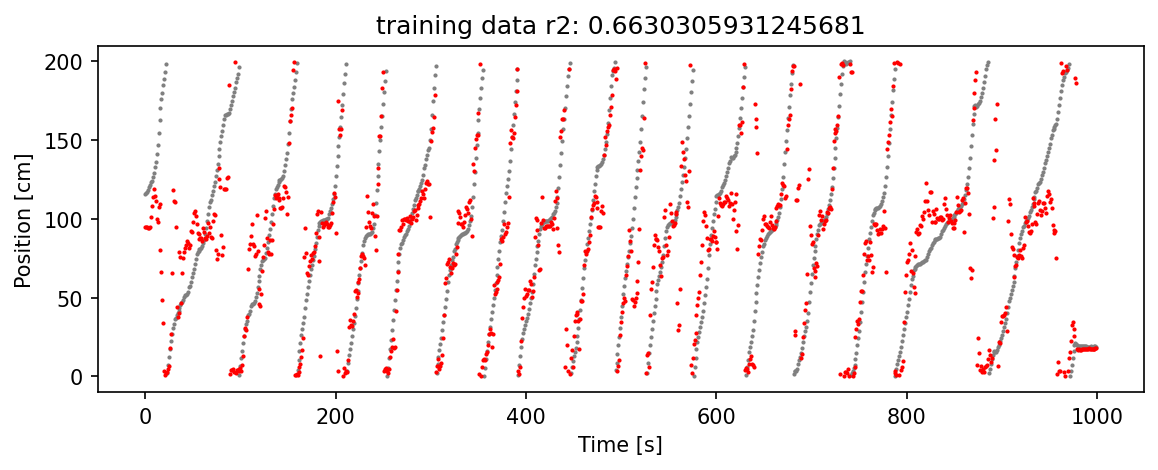

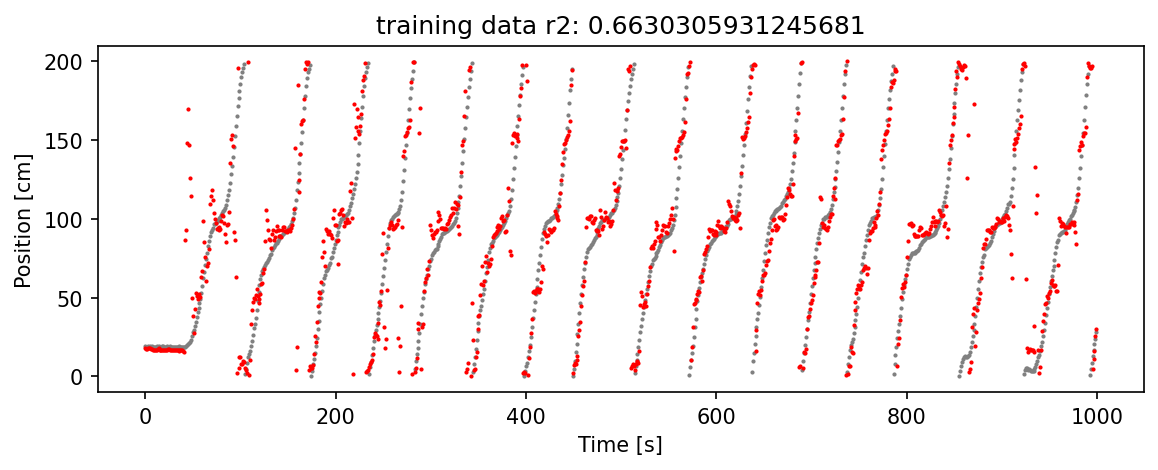

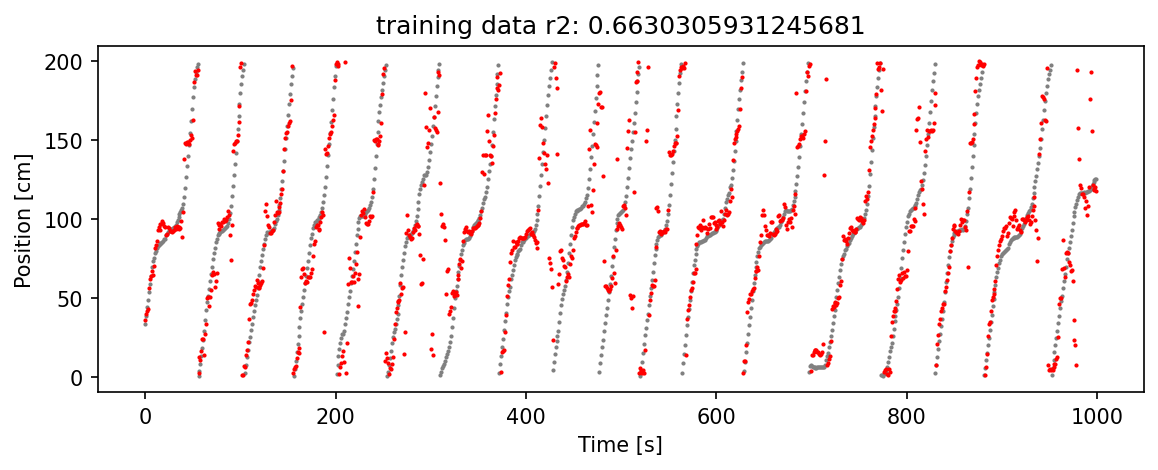

ValueError: x and y must be the same size

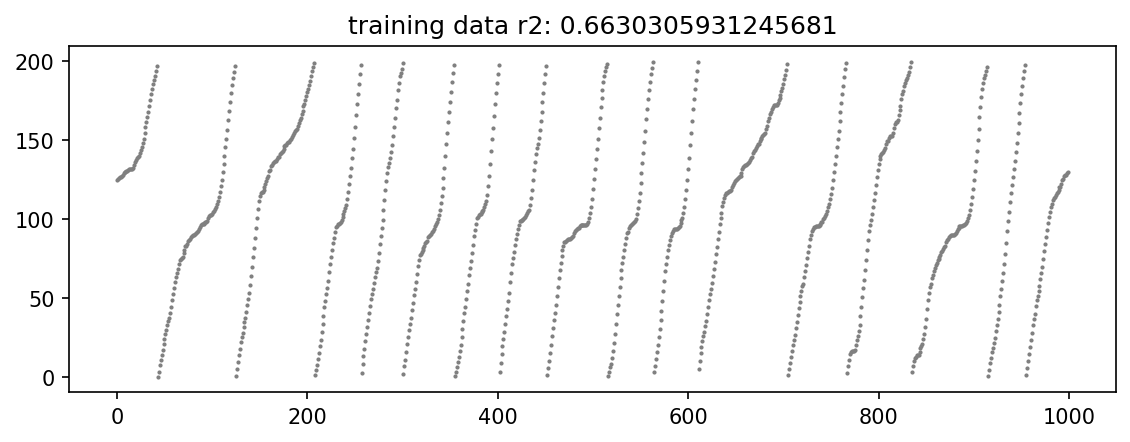

In [7]:
n_samples_per_plot = 1000

original_train = decode_2d_to_1d(label_train)
decoded_train = decode_2d_to_1d(train_pos_pred)

for i in range(int(n_samples/n_samples_per_plot)):
    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    ax.set_title(f'training data r2: {train_test_score}')
    ax.scatter(np.arange(len(original_train))[:n_samples_per_plot], original_train[int(i*n_samples_per_plot):int((i+1)*n_samples_per_plot)], c='gray', s=1)
    ax.scatter(np.arange(len(decoded_train))[:n_samples_per_plot], decoded_train[int(i*n_samples_per_plot):int((i+1)*n_samples_per_plot)], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.show()

(1000,)
(999,)


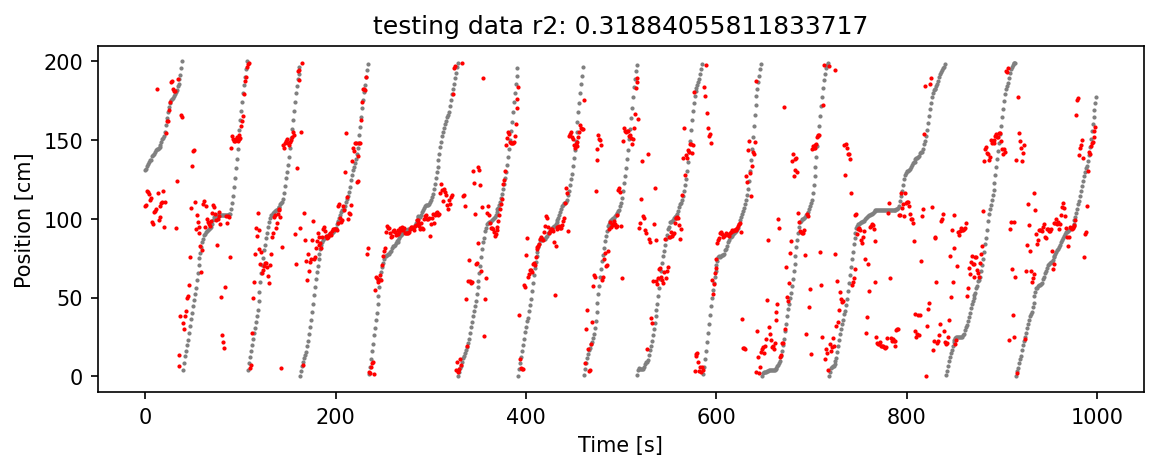

ValueError: x and y must be the same size

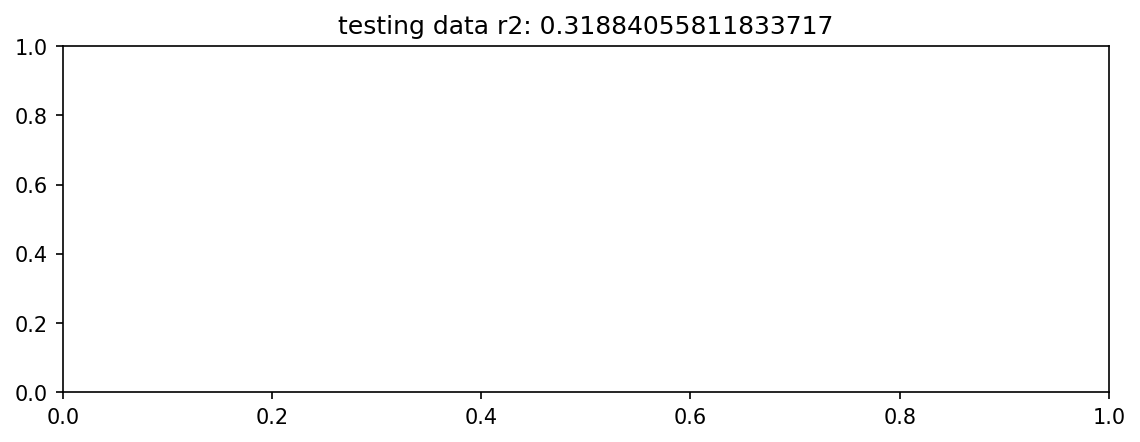

In [9]:
n_samples_per_plot = 1000

original_test = decode_2d_to_1d(label_test)
decoded_test = decode_2d_to_1d(test_pos_pred)

for i in range(int(n_samples/n_samples_per_plot)):
    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    ax.set_title(f'testing data r2: {test_test_score}')
    ax.scatter(np.arange(len(original_test))[:n_samples_per_plot], original_test[int(i*n_samples_per_plot):int((i+1)*n_samples_per_plot)], c='gray', s=1)
    ax.scatter(np.arange(len(decoded_test))[:n_samples_per_plot], decoded_test[int(i*n_samples_per_plot):int((i+1)*n_samples_per_plot)], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.show()

In [8]:
len(original_train)

4000

In [11]:
print(list(spike_data))

['session_id', 'cluster_id', 'firing_times', 'mean_firing_rate', 'shank_id', 'amplitude_cutoff', 'amplitude_cv_median', 'amplitude_cv_range', 'amplitude_median', 'drift_ptp', 'drift_std', 'drift_mad', 'firing_range', 'firing_rate', 'isi_violations_ratio', 'isi_violations_count', 'num_spikes', 'presence_ratio', 'rp_contamination', 'rp_violations', 'sd_ratio', 'sliding_rp_violation', 'snr', 'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'speed_per200ms', 'x_position_cm', 'trial_number', 'trial_type', 'stop_locations', 'stop_trial_numbers', 'fr_time_binned_smoothed', 'fr_time_binned_bin_centres', 'fr_time_binned', 'fr_binned_in_space_smoothed', 'fr_binned_in_space_bin_centres', 'fr_binned_in_space', 'ls_powers', 'ls_centre_distances', 'ls_freqs', 'ls_deltas']


In [ ]:
len(original_test[:n_samples])